# Double DQN

In this notebook, we will implement Deep Q-Learning Reinforcement learning algorithm for Lunar Lander Environment.

## Lunar Lander

This environment is a classic rocket trajectory optimization problem. The landing pad is always at coordinates (0,0). The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

There are four discrete actions available:<br>
- 0: do nothing<br>
- 1: fire left orientation engine<br>
- 2: fire main engine<br>
- 3: fire right orientation engine<br>

After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:

- is increased/decreased the closer/further the lander is to the landing pad.

- is increased/decreased the slower/faster the lander is moving.

- is decreased the more the lander is tilted (angle not horizontal).

- is increased by 10 points for each leg that is in contact with the ground.

- is decreased by 0.03 points each frame a side engine is firing.

- is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered a solution if it scores at least 200 points.


You can read more the LunarLander environment [here](https://gymnasium.farama.org/environments/box2d/lunar_lander/)

![LunarLander](https://gymnasium.farama.org/_images/lunar_lander.gif)

## Deep Q-Learning

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

But this is not scalable. Must compute $Q(s,a)$ for every state-action pair. If state is e.g. current game state pixels, computationally infeasible to compute for entire state space! But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

To minimise this error, we will use the `Huber
loss <https://en.wikipedia.org/wiki/Huber_loss>`__. The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate
this over a batch of transitions, $B$, sampled from the replay
memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}



### Double Deep Q-Learning

We will implement Double Deep Q-Learning here. Double Deep Q-Learning is used to reduce the maximaztion bias in Q-Learning. This entails separate action selection and action evaluation in the target value.

- Use the current network to select the max action for the next state
and then use the target network to get the target Q-value for that
action.




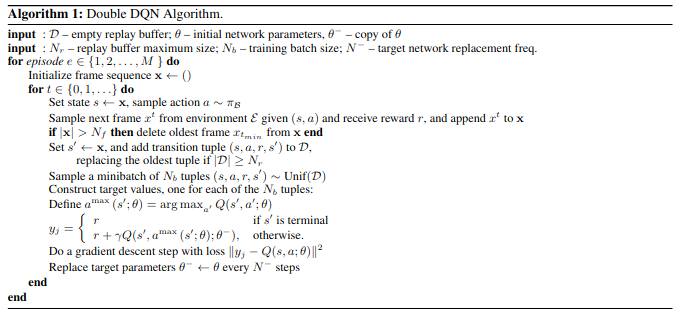

[Image Source](https://leejungi.github.io/posts/Dueling-DQN/)

In [5]:
!pip install -q swig
!pip install -q gym[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 60.3 MB/s eta 0:00:00


In [6]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [7]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# Create the environment
env = gym.make("LunarLander-v2")

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


### Experience Replay

Learning from batches of consecutive samples is problematic as the sample are correlated and it can create a bad feedback loop if one action is dominated in the samples.

We can address these problems using an experience replay memory. It maintains a record for all the transitions experienced. The agent is then trained by sampling random minibatches from the replay memory.

In [9]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))


class ReplayMemory(object):
  def __init__(self, capacity):
    self.capacity = capacity
    self.memory = []
    self.position = 0

  def push(self, *args):
    if len(self.memory) < self.capacity:
      self.memory.append(None)
    self.memory[self.position] = Transition(*args)
    self.position = (self.position + 1) % self.capacity

  def sample(self, batch_size):
    return random.sample(self.memory, batch_size)

  def __len__(self):
    return len(self.memory)

### Q-Network

In [10]:
class DQN(nn.Module):
  def __init__(self, n_observations, n_actions):
    super(DQN, self).__init__()
    self.layer1 = nn.Linear(n_observations, 128)
    self.layer2 = nn.Linear(128,128)
    self.layer3 = nn.Linear(128,n_actions)

  def forward(self, x):
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    return self.layer3(x)

### Exploration vs Exploitation

Notice that Q-learning only learns about the states and actions it visits. What if an optimal state remains unvisited due to not being explored. The agent should sometimes pick suboptimal actions in order to visit new states and actions. <br>

A simple strategy is to use an $\epsilon$-greedy policy. According to this policy, the agent takes a random action with epsilon probability. The value of epsilon is high at the start of training and low towards the end. So, the agent explores more at the start and then exploit the learned policy more at the end.

### Hyperparameters

In [26]:
# Here, we will specify the hyperparameters
total_episodes = 3000
max_steps = 200
learning_rate = 0.005
gamma = 0.95
batch_size = 128
target_update = 4
train_freq = 1
train_epochs = 5

epsilon = 1.0
max_epsilon = 1.0
min_epsilon = 0.1
decay_rate = 0.001

### Training

In [12]:
# Code here
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [13]:
policy_net = DQN(state_size, action_size).to(device)
target_net = DQN(state_size, action_size).to(device)



target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

memory = ReplayMemory(10000)

In [14]:

def get_action(state):
  exp_exp_tradeoff = random.uniform(0,1)
  if exp_exp_tradeoff > epsilon:
    with torch.no_grad():
      action = policy_net(state).max(1)[1].view(1,1)

  else:
    action = env.action_space.sample()
    action = torch.tensor([action], device=device).view(1,1)
  return action

In [30]:
rewards = []

for episode in range(1,total_episodes+1):
  state = env.reset()
  state = torch.tensor([state], device=device)
  total_rewards = 0
  for _ in range(max_steps):
    action = get_action(state)
    next_state, reward, done, _ = env.step(action.item())

    total_rewards +=reward

    reward = torch.tensor([reward], device=device)
    done = torch.tensor([int(done)], device=device)
    next_state = torch.tensor([next_state], device=device)

    memory.push(state, action, next_state, reward, done)

    state = next_state

    if done:
      break

  if episode % train_freq == 0 and len(memory)>=batch_size:
    transitions = memory.sample(batch_size)

    batch = Transition(*zip(*transitions))

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    next_state_batch = torch.cat(batch.next_state)
    reward_batch = torch.cat(batch.reward)
    done_batch = torch.cat(batch.done)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    with torch.no_grad():
     best_actions = policy_net(next_state_batch).argmax(1)
     next_state_values = target_net(next_state_batch).gather(1, best_actions.unsqueeze(1)).squeeze(1)
    # Compute the target Q values
    target_q_values = (next_state_values * (1-done_batch) * gamma) + reward_batch


    loss = F.smooth_l1_loss(state_action_values, target_q_values.unsqueeze(1))


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if episode % target_update ==0:
      target_net.load_state_dict(policy_net.state_dict())

    epsilon = min_epsilon + (max_epsilon - min_epsilon)* np.exp(-decay_rate*episode)
    rewards.append(total_rewards)

In [35]:
def test_optimal_policy(env, policy_net, device, num_episodes=100):
    """
    Evaluate the optimal policy learned by the DQN agent.

    Returns:
        The average total reward over the test episodes.
    """
    total_rewards = 0
    for _ in range(num_episodes):
        state = env.reset()
        state = torch.tensor([state], device=device)
        done = False
        episode_reward = 0

        while not done:
            with torch.no_grad():
                action = policy_net(state).argmax().view(1, 1)
            state, reward, done, _ = env.step(action.item())
            state = torch.tensor([state], device=device)
            episode_reward += reward

        total_rewards += episode_reward

    average_reward = total_rewards / num_episodes
    print(f"Average reward over {num_episodes} episodes: {average_reward:.2f}")
    return average_reward

In [36]:
test_optimal_policy(env, policy_net, device)

# Performance Analysis:
#The average reward over the last 100 episodes is -49.58, which is a significant improvement from the initial -868.00 you had provided.

Average reward over 100 episodes: -49.85


-49.846250232178036

### Visualization

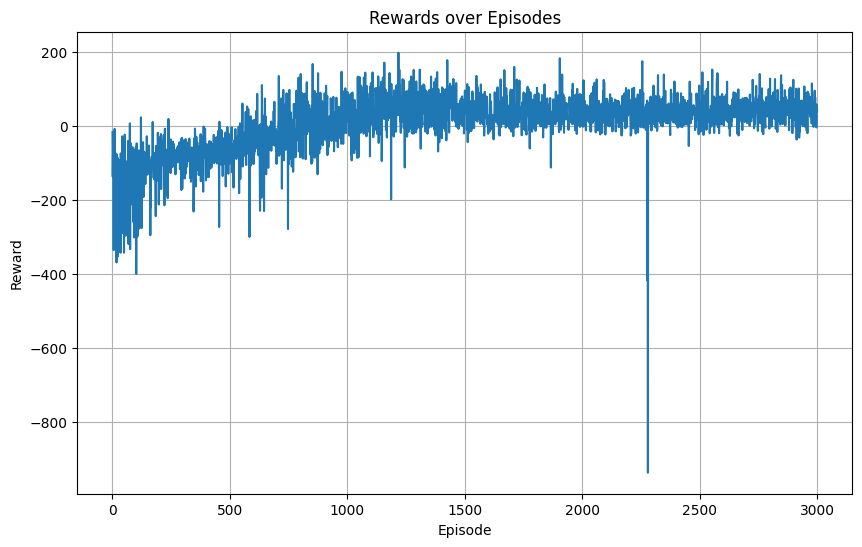

In [37]:
import matplotlib.pyplot as plt

# Assuming the rewards are stored in the 'rewards' list
episode_count = len(rewards)
x = range(1, episode_count + 1)  # Episode numbers

plt.figure(figsize=(10, 6))
plt.plot(x, rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards over Episodes')
plt.grid(True)
plt.show()

In [38]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'                                   # disable video display

In [39]:
os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state = env.reset()
    state = torch.tensor([state], device=device)
    done = False
    for t in range(max_steps):
        vid.capture_frame()

        action =  get_action(state)
        action = torch.tensor([action], device=device).view(1,1)
        action = action.cpu().numpy()
        action = np.clip(action, 0, 3).astype(int)[0,0]

        next_state, reward, done, info = env.step(action)
        next_state = torch.tensor([next_state], device=device)
        print(f"state: {state}, action: {action}, reward: {reward}, done: {done}")
        state = next_state
        if done:
            break
    vid.close()
    env.close()

In [40]:
show_video_of_model("LunarLander-v2")

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


state: tensor([[ 0.0015,  1.4044,  0.1477, -0.2903, -0.0017, -0.0335,  0.0000,  0.0000]]), action: 2, reward: 4.0066886663027335, done: False
state: tensor([[ 0.0028,  1.3988,  0.1384, -0.2505, -0.0038, -0.0425,  0.0000,  0.0000]]), action: 2, reward: 1.4877388868460286, done: False
state: tensor([[ 0.0042,  1.3935,  0.1366, -0.2345, -0.0060, -0.0445,  0.0000,  0.0000]]), action: 1, reward: -1.4211782965132886, done: False
state: tensor([[ 0.0054,  1.3876,  0.1275, -0.2613, -0.0064, -0.0079,  0.0000,  0.0000]]), action: 2, reward: 3.805758164043465, done: False
state: tensor([[ 0.0066,  1.3826,  0.1213, -0.2231, -0.0072, -0.0148,  0.0000,  0.0000]]), action: 2, reward: 2.379207926428518, done: False
state: tensor([[ 0.0079,  1.3782,  0.1275, -0.1927, -0.0076, -0.0092,  0.0000,  0.0000]]), action: 1, reward: -1.2012813204156874, done: False
state: tensor([[ 0.0091,  1.3733,  0.1179, -0.2195, -0.0062,  0.0294,  0.0000,  0.0000]]), action: 2, reward: 3.267031395189048, done: False
state: 

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


state: tensor([[ 1.3807e-02,  1.3581e+00,  1.1808e-01, -1.4156e-01, -8.0548e-04,
          2.8324e-02,  0.0000e+00,  0.0000e+00]]), action: 1, reward: -1.4738168045071223, done: False
state: tensor([[ 0.0149,  1.3543,  0.1099, -0.1684,  0.0022,  0.0610,  0.0000,  0.0000]]), action: 2, reward: 0.05784714904957583, done: False
state: tensor([[ 0.0161,  1.3506,  0.1100, -0.1649,  0.0053,  0.0611,  0.0000,  0.0000]]), action: 2, reward: 3.555487785733715, done: False
state: tensor([[ 0.0171,  1.3477,  0.0978, -0.1266,  0.0078,  0.0496,  0.0000,  0.0000]]), action: 2, reward: 2.715574579210579, done: False
state: tensor([[ 0.0180,  1.3456,  0.0885, -0.0951,  0.0098,  0.0410,  0.0000,  0.0000]]), action: 1, reward: -1.718914652776134, done: False
state: tensor([[ 0.0188,  1.3428,  0.0788, -0.1224,  0.0138,  0.0797,  0.0000,  0.0000]]), action: 2, reward: 0.4538486170753913, done: False
state: tensor([[ 0.0195,  1.3401,  0.0623, -0.1227,  0.0170,  0.0639,  0.0000,  0.0000]]), action: 1, rewar

In [41]:
show_video("LunarLander-v2")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
